# **V6 on Real Datatest**

In [1]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from utils.wrapper import YOLOAPIWrappper
from utils.pipeline import CPPipeline

### **Additive**

In [2]:
v6 = "../utils/v6/bestv6.onnx"
yolov6_detector_real = YOLOAPIWrappper(v6,file_path='../calibration/calibv6_real_a.pickle', conf_thres=0.7, iou_thres=0.5)
pipev6_real = CPPipeline(yolov6_detector_real, test_set='test_real', method='additive')

In [3]:
X_train, y_train, labels_train= pipev6_real.extract_yolo_dataset()
X_train, X_val, y_train, y_val, labels_train, labels_val = pipev6_real.calibration_and_val(X_train, y_train, labels_train)
conformal_predictor= pipev6_real.pipeline( X_train=X_train, y_train= y_train, labels_train= labels_train)

Predictions: [[2679.93237305  332.45111084 3574.91137695  935.21417236]
 [1958.61572266 1099.95751953 2180.421875   1258.89770508]
 [2148.41845703  767.54229736 2219.60058594  867.94696045]
 [2589.78662109  546.10931396 2626.43164062  597.48675537]
 [ 813.14764404  345.51339722  842.05218506  389.91952515]
 [2347.13183594  610.63330078 2651.07861328  792.33312988]
 [1835.89550781  870.94299316 2198.9387207  1058.25183105]
 [2122.62939453  965.18444824 2281.68408203 1086.46789551]
 [1500.65429688  953.10479736 1597.20678711 1048.84082031]
 [2487.78515625  680.63409424 2537.58837891  752.78607178]
 [1734.22998047  924.94787598 1872.59375    1035.5012207 ]
 [1646.66540527  967.32421875 1689.60925293 1027.8581543 ]
 [2190.09594727  543.58508301 2353.75268555  690.45825195]
 [2485.80249023  530.00170898 2657.64038086  660.71142578]
 [2260.46264648  639.28137207 2371.85229492  750.14916992]
 [1916.95788574  858.54846191 2227.85253906 1026.3338623 ]
 [2915.95776367  793.55358887 3226.45141602

Predictions: (array([[1841.824 , 1177.3192, 2105.489 , 1322.9525]], dtype=float32), array([0.9519153], dtype=float32))
Marginal coverage: 0.0
Average area: 44776.1484375
Confidence score : [0.9519153]


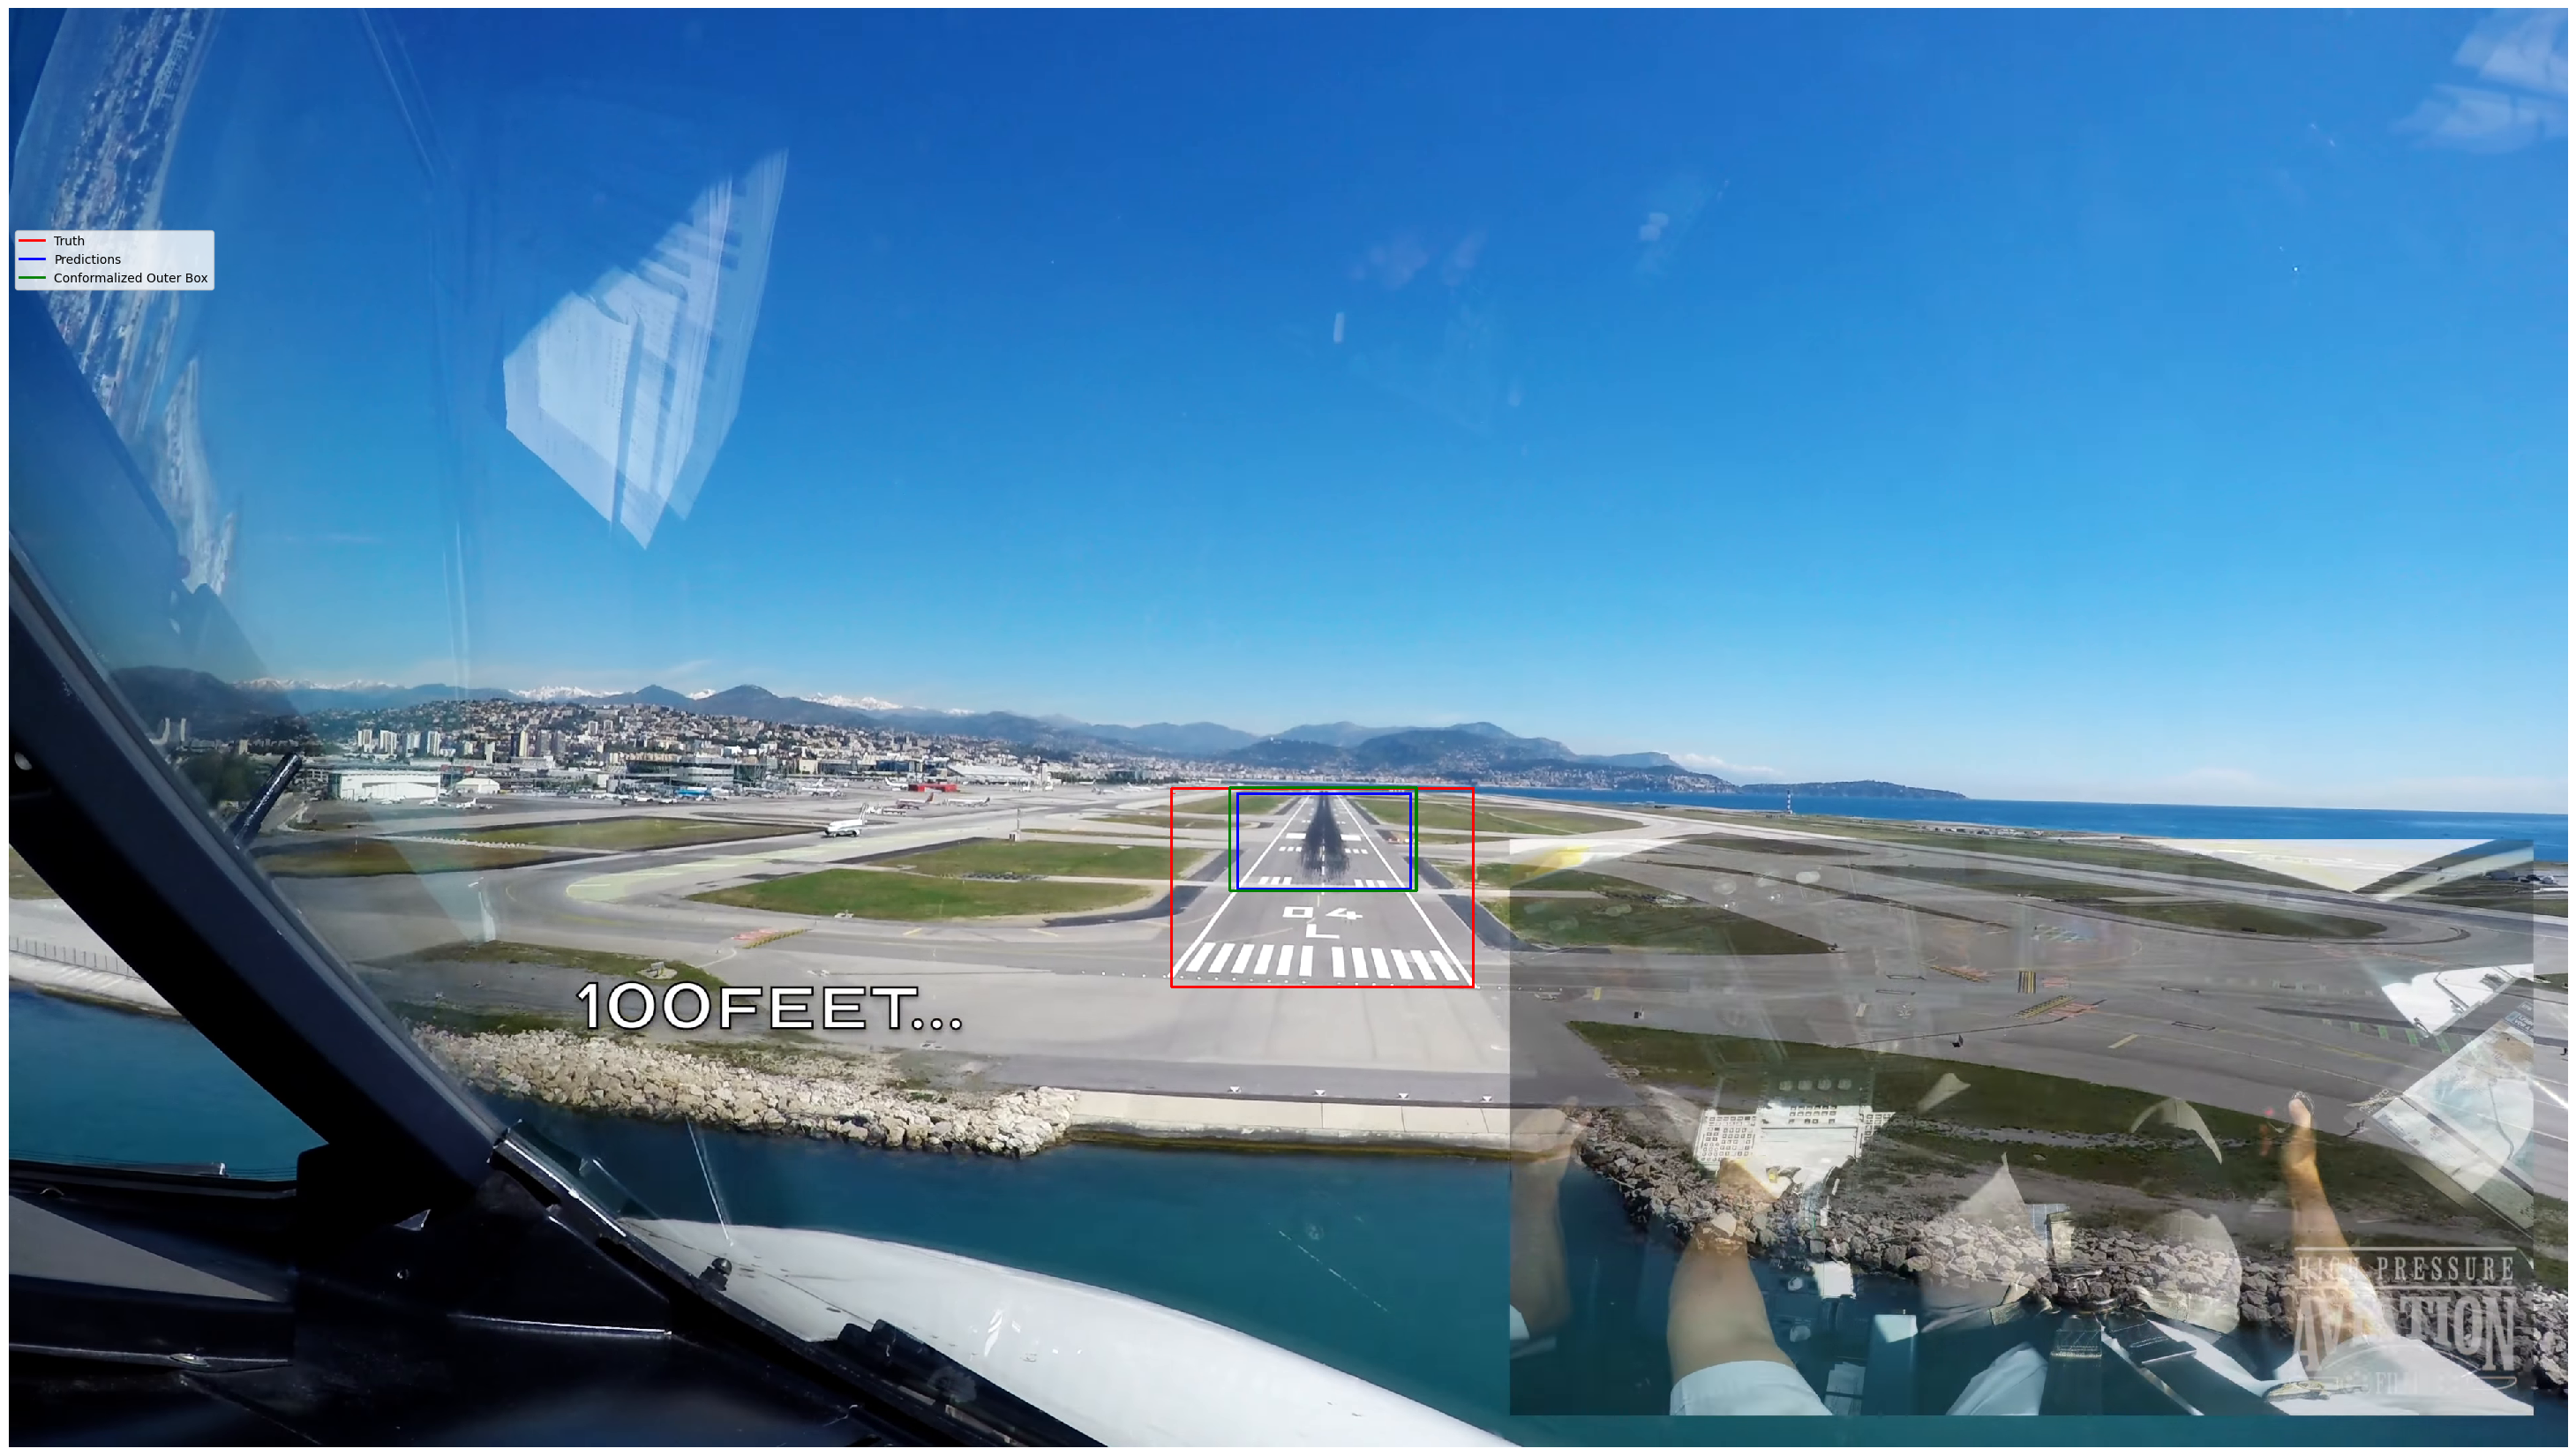

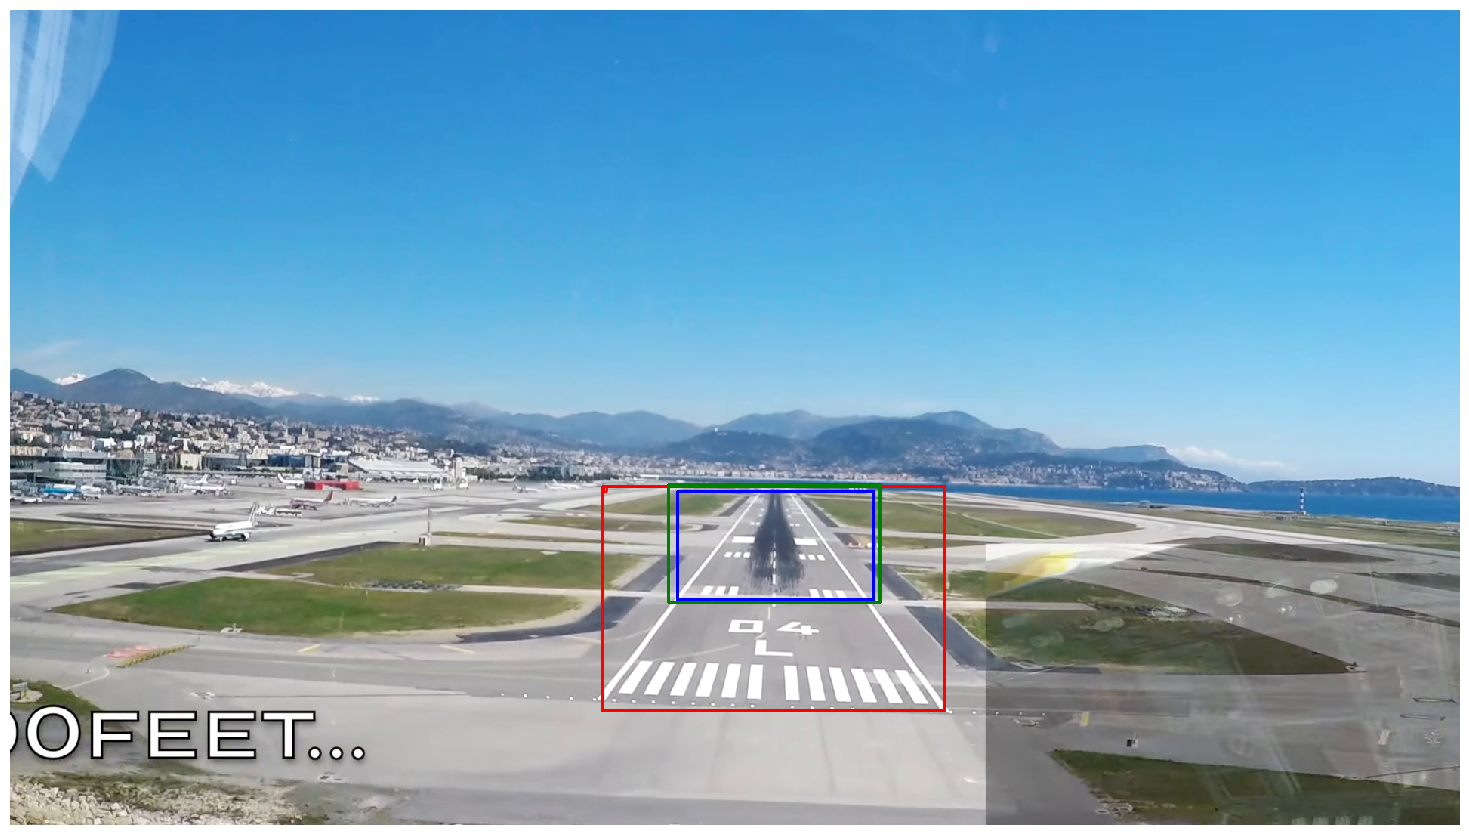

In [4]:
pipev6_real.infer_eval_single_image(
    conformal_predictor, 
    X_val[4],  # Image path at index 5
    y_val[4],  # Ground truth bounding boxes at index 5
    labels_val[4],  # Labels at index 5
    None  
)

In [5]:
y_pred_val, y_true_val, images_val, classes_val,score_val, box_inner_val, box_outer_val = pipev6_real.infer_all_images(conformal_predictor,X_val, y_val, labels_val, visualize = False)

Number of images: 21
Number of images without predictions: 5
Number of images with predictions: 16


In [6]:
average_glo_area, cover = pipev6_real.average_cover_and_area(y_pred_val, y_true_val, box_outer_val)

Average area of prediction intervals: 59190.328125
Average length of prediction intervals: 243.29061889648438
Average Marginal coverage: 0.375


In [7]:
import os
import pandas as pd
from utils.helpers import iou, ioa

filenames = []
all_preds = []
all_trues = []
all_classes = []
iou_pred_c_gt = []
ioa_pred_c_gt = []
iou_pred_gt = []
ioa_pred_gt = []
score = []
box_inner = []
box_outer = []
all_cover = []
glo_area = []


for y_pred_, y_true_, img_path_, clss_, score_, box_inner_, box_outer_, cover_, avg_area_ in zip(y_pred_val, y_true_val, X_val, classes_val, score_val, box_inner_val, box_outer_val, cover, average_glo_area):


    filenames.append(os.path.basename(img_path_))
    all_preds.append(y_pred_)
    all_trues.append(y_true_)
    all_classes.append(clss_)
    iou_pred_c_gt.append(iou(box_outer_.flatten(), y_true_.flatten())) # iou between outer box and gt
    ioa_pred_c_gt.append(ioa(box_outer_.flatten(), y_true_.flatten())) # ioa between outer box and gt
    iou_pred_gt.append(iou(y_pred_.flatten(), y_true_.flatten()))   # iou between yolo pred and gt
    ioa_pred_gt.append(ioa(y_pred_.flatten(), y_true_.flatten()))  # ioa between yolo pred and gt
    score.append(score_) # confidence score
    box_inner.append(box_inner_)
    box_outer.append(box_outer_)
    all_cover.append(cover_) #cover between conformal box and gt
    glo_area.append(avg_area_)

df = pd.DataFrame({
    'filename': filenames,
    'pred_yolo': all_preds,
    'gt': all_trues,
    'class': all_classes,
    'iou_pred_c_gt': iou_pred_c_gt,
    'ioa_pred_c_gt': ioa_pred_c_gt,
    'iou_pred_gt': iou_pred_gt,
    'ioa_pred_gt': ioa_pred_gt,
    'score': score,
    'box_inner': box_inner,
    'box_outer': box_outer,
    'cover': cover,
    'avg_area': glo_area
})

all = pd.read_csv("/home/aws_install/conformal_runway_detection/surrogate/all_test_with_real.csv")

all_subset = all[['filename', 'slant_distance', 'time_to_landing']]

df = pd.merge(df, all_subset, on='filename', how='left')

df.to_csv('results_v6_real_a.csv', index=False)